# PA-X actor networks

Model of signatories to peace agreements. The head vertex of an edge is always an agreement although the graph appears be handled as undirected in the Tracker.

## TODO

- Build main graph and queries from matrix

## Data issues

- AGT type is undefined in nodes CSV
- Some missing agreements



In [1]:
__author__      = 'Roy Gardner'

import networkx as nx
from networkx.readwrite import json_graph

import numpy as np
import matplotlib.pyplot as plt

import json
import os
import csv
import sys

import ipywidgets as widgets

twenty_distinct_colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0',\
                          '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8',\
                          '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff',\
                          '#000000']


## Illustrate matrix operations

- Simulate an agreement-actor matrix A with 4 agreements in rows and 3 actor in columns
- A cell value of 1 means actor is signatory of an agreement
- Product of transpose of A and A gives a 3x3 matrix where:
    - The diagonal provides the column marginals of A, i.e., the number of occurences of an actor over all agreeemnts
    - The upper triangle provides agreement co-occurence counts for a pair of actors
- Product of A and transpose A gives a 4x34 matrix where:
    - The diagonal provides the row marginals of A, i.e., the number of actors in an agreeemnt
    - The upper triangle provides the actor co-occurencre counts for a pair of agreements
    

In [2]:
# Agreement-actor matrix
A = []
A.append([1,1,0])
A.append([0,0,0])
A.append([1,1,0])
A.append([1,0,1])

A = np.array(A)

V = np.matmul(A.T,A)
print(V)
print()

W = np.matmul(A,A.T)
print(W)


[[3 2 1]
 [2 2 0]
 [1 0 1]]

[[2 0 2 1]
 [0 0 0 0]
 [2 0 2 1]
 [1 0 1 2]]


## PeaceRep signatory data


In [6]:
# Read the CSVs
with open('./data/node_table.csv', encoding='utf-8', errors='replace') as f:
    reader = csv.reader(f)
    # Get the header row
    nodes_header = next(reader)
    # Put the remaining rows into a list of lists
    nodes_data = [row for row in reader]
    
with open('./data/links_table.csv', encoding='utf-8', errors='replace') as f:
    reader = csv.reader(f)
    # Get the header row
    links_header = next(reader)
    # Put the remaining rows into a list of lists
    links_data = [row for row in reader]

with open('./data/agreements_dict.json') as f:
    agreements_dict = json.load(f)
    
# Build a vertices dictionary with node_id as key
vertices_dict = {row[nodes_header.index('node_id')]:row for row in nodes_data}

# Collect all vertex types
vertex_types = []
for k,v in vertices_dict.items():
    type_ = v[nodes_header.index('type')]
    if len(type_) == 0:
        type_ = 'AGT'
    vertex_types.append(type_)
vertex_types = sorted(list(set(vertex_types)))
print(vertex_types)

# Build a colour map for types (empty type is annoying)
color_map = {type_:twenty_distinct_colors[i] for i,type_ in enumerate(vertex_types)}


['AGT', 'ARM', 'COA', 'CON', 'ENT', 'IGO', 'MIL', 'NGO', 'OTH', 'POL', 'UMB']


In [7]:
print(nodes_header)
print()

print(links_header)
print()

['overall_node_type', 'id', 'type', 'node_id', 'node_type', 'node_name', 'abbreviation', 'country_based', 'node_country', 'ucdp_id', 'in_ucdp', 'acled_name', 'acled_other', 'alternative_names', 'description', 'date', 'year', 'month', 'day', 'month_full', 'PP', 'PPName', 'Loc2ISO']

['signatory_id', 'date', 'year', 'month', 'day', 'from_node_id', 'from_id', 'from_node_name', 'from_node_type', 'PPName', 'signatory_type', 'to_id', 'to_node_id', 'to_node_name', 'abbreviation', 'to_node_type']



## Query a peace process

In [8]:
process_name = 'Bosnia peace process'

# Get section set counts for Bosnia agreements
with open('./data/counts_dict.json') as f:
    section_counts_dict = json.load(f)


bosnia_edges = [row for row in links_data if row[links_header.index('PPName')].strip()==process_name]
print(len(bosnia_edges))
print()

# Collect from_node_id values
bosnia_from_vertices = list(set([row[links_header.index('from_node_id')] for row in bosnia_edges]))
print(bosnia_from_vertices)
print()

# Collect to_node_id values
bosnia_to_vertices = list(set([row[links_header.index('to_node_id')] for row in bosnia_edges]))
print(bosnia_to_vertices)
print()

all_vertices = []
all_vertices.extend(bosnia_from_vertices)
all_vertices.extend(bosnia_to_vertices)
all_vertices = list(set(all_vertices))

# Count each type for peace process
counts = []
for vertex_type in vertex_types:
    counts.append((vertex_type,len([v for v in all_vertices if v.split('_')[0]==vertex_type])))
counts = sorted(counts,key=lambda t:t[1],reverse=True)
print(counts)

# Build an edge dictionary with agreement as key and list of actors as value
edge_dict = {}
for row in bosnia_edges:
    if row[5] in edge_dict:
        edge_dict[row[5]].append(row[12])
    else:
        edge_dict[row[5]] = [row[12]]


540

['AGT_1849', 'AGT_608', 'AGT_1474', 'AGT_1869', 'AGT_1903', 'AGT_1504', 'AGT_1931', 'AGT_1226', 'AGT_1476', 'AGT_1177', 'AGT_1198', 'AGT_1165', 'AGT_1490', 'AGT_311', 'AGT_547', 'AGT_1624', 'AGT_1617', 'AGT_1477', 'AGT_1628', 'AGT_1213', 'AGT_1590', 'AGT_1598', 'AGT_1475', 'AGT_1320', 'AGT_1928', 'AGT_1632', 'AGT_1618', 'AGT_1848', 'AGT_1627', 'AGT_77', 'AGT_1470', 'AGT_1654', 'AGT_1164', 'AGT_472', 'AGT_1494', 'AGT_916', 'AGT_1643', 'AGT_1479', 'AGT_1289', 'AGT_1500', 'AGT_1212', 'AGT_1182', 'AGT_1640', 'AGT_1169', 'AGT_1622', 'AGT_1626', 'AGT_1201', 'AGT_1630', 'AGT_1501', 'AGT_1591', 'AGT_1619', 'AGT_1847', 'AGT_2', 'AGT_384', 'AGT_915', 'AGT_1482', 'AGT_1639', 'AGT_1589', 'AGT_1636', 'AGT_1930', 'AGT_1633', 'AGT_1625', 'AGT_1616', 'AGT_1486', 'AGT_1214', 'AGT_276', 'AGT_1610', 'AGT_1166', 'AGT_1205', 'AGT_1872', 'AGT_1484', 'AGT_1030', 'AGT_1878', 'AGT_1459', 'AGT_1027', 'AGT_1876', 'AGT_1202', 'AGT_1620', 'AGT_1483', 'AGT_1877', 'AGT_1167', 'AGT_1503', 'AGT_1209', 'AGT_389', 

## Build and plot a undirected multigraph

Why a multigraph? Because an actor can be both party and third-party.


In [9]:
graph = nx.MultiGraph()

vertices = []
vertices.extend(bosnia_from_vertices)
vertices.extend(bosnia_to_vertices)
graph.add_nodes_from(vertices)
for row in bosnia_edges:
    from_vertex = row[links_header.index('from_node_id')]
    to_vertex = row[links_header.index('to_node_id')]
    graph.add_edge(from_vertex,to_vertex,weight=1)

# Count the edges
print(len(graph.edges))


540


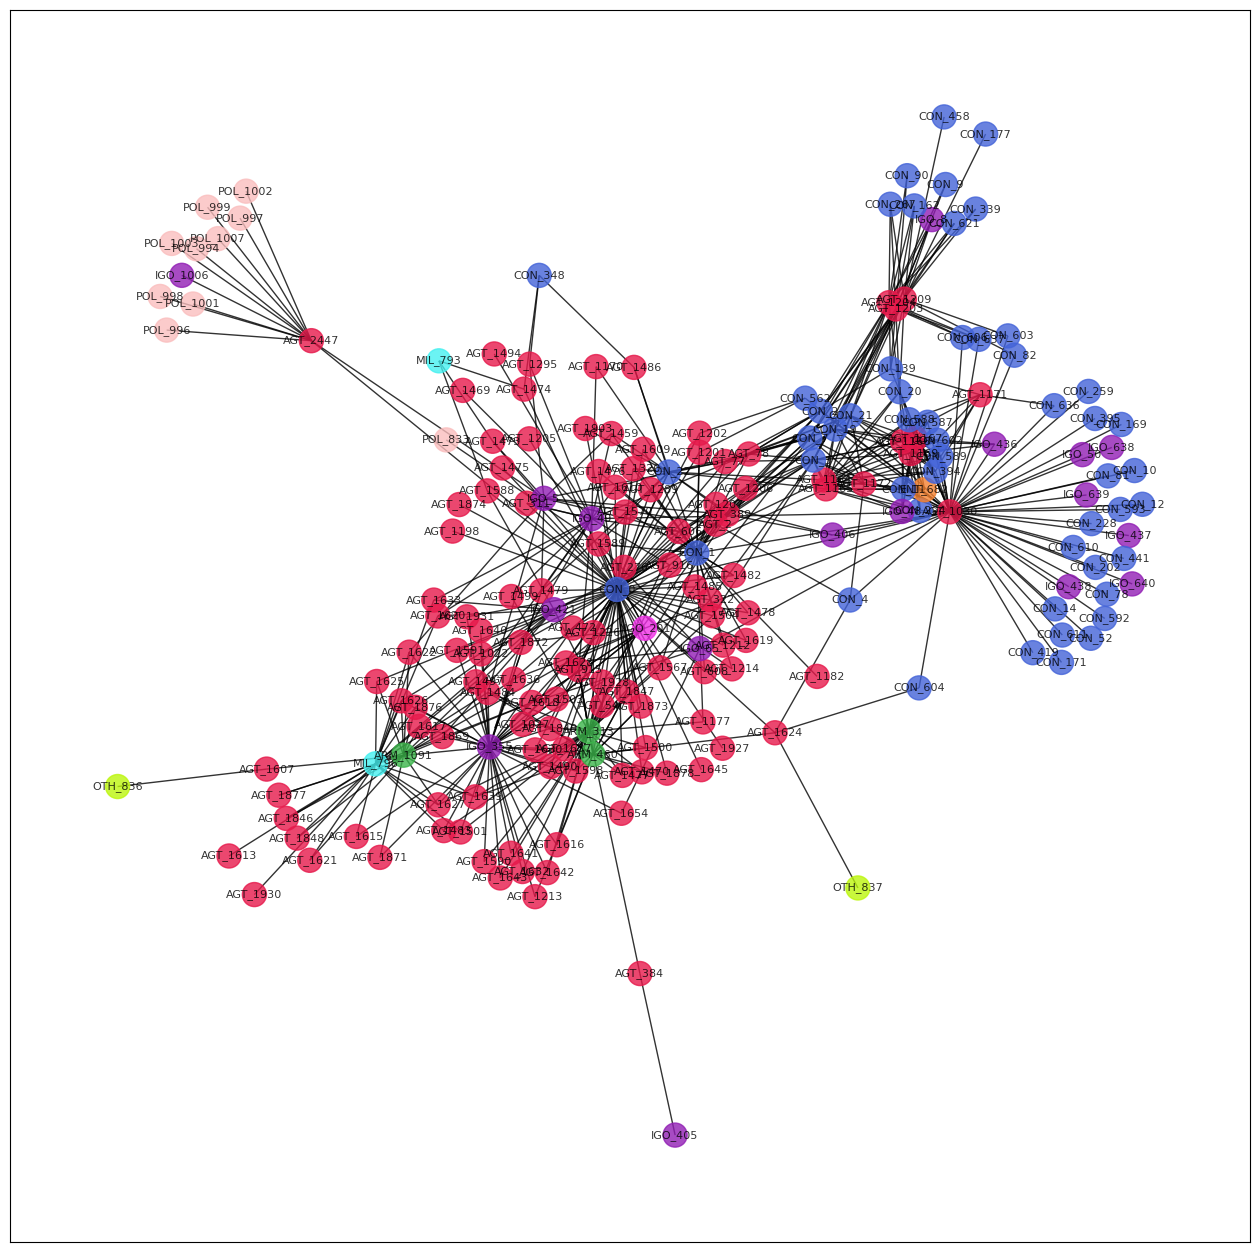

In [10]:

node_colors = [color_map[v.split('_')[0]] for v in vertices]

f = plt.figure(figsize=(16,16))
pos = nx.spring_layout(graph) 
nx.draw_networkx(graph,pos,node_color=node_colors,font_size='8',alpha=0.8)
plt.grid(False)
plt.show()


## Query vertices using depth-first search

CON_20 China
CON_21 Russia

Found edges: 18


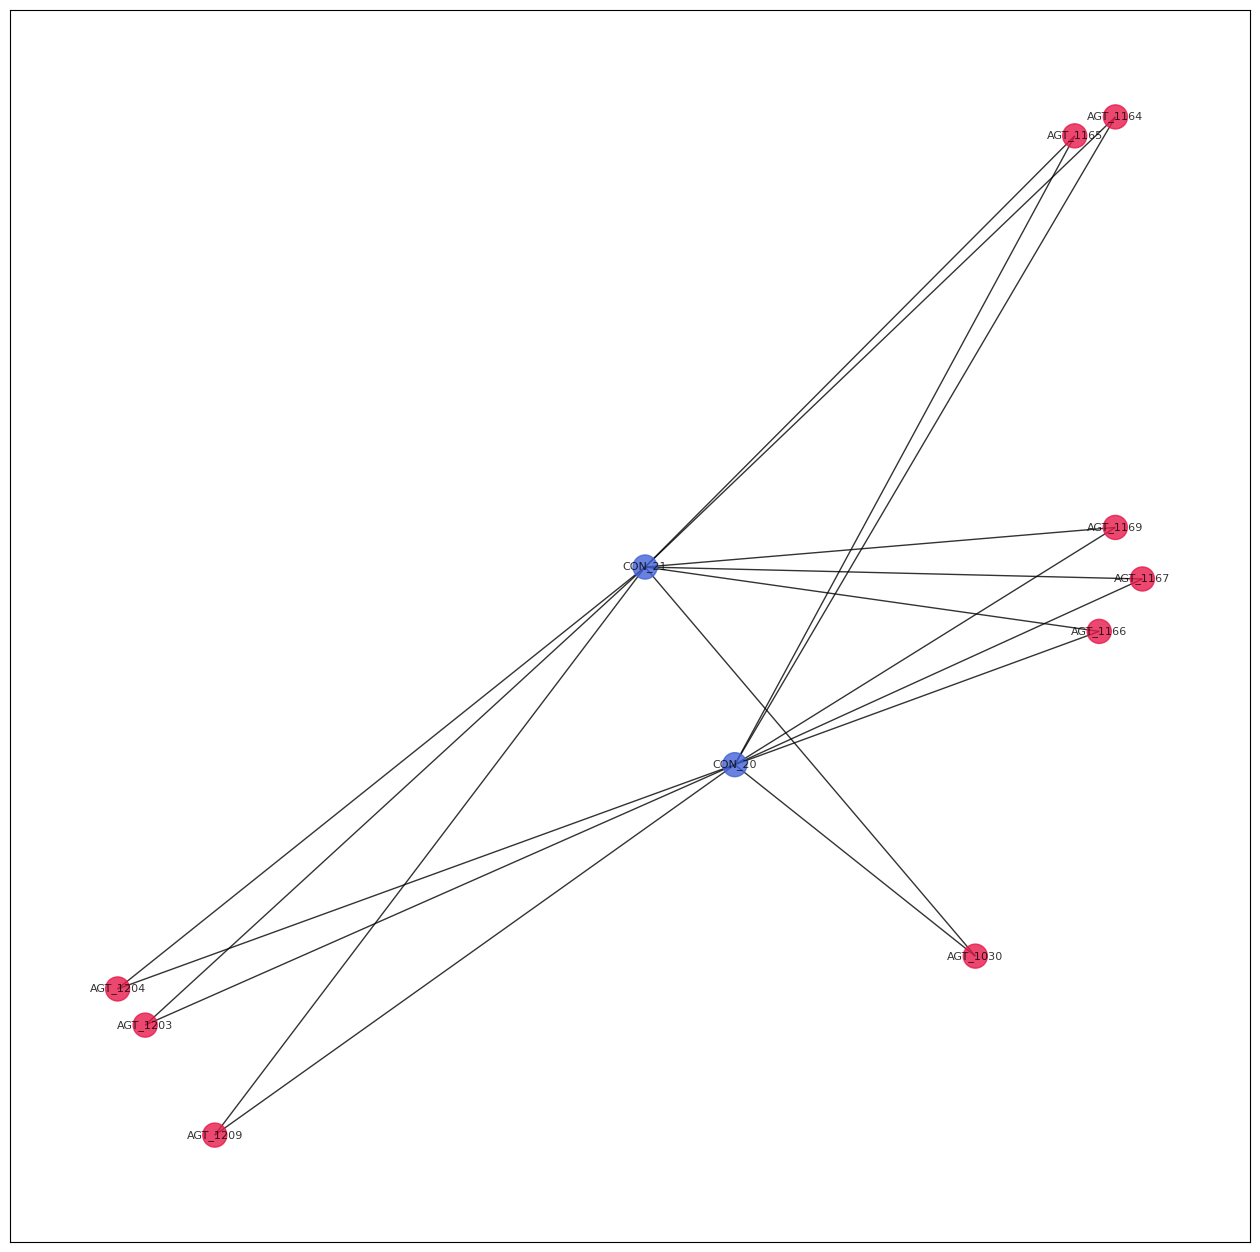

In [11]:
operator = 'AND'
depth = 1

query_vertices = ['IGO_5','CON_2','CON_4']
query_vertices = ['IGO_5']
query_vertices = ['AGT_2']
query_vertices = ['IGO_5','CON_2','CON_3']
#query_vertices = ['NGO_201']
#query_vertices = ['CON_3','CON_19']
#query_vertices = ['CON_0']

# Dayton and conclusions
query_vertices = ['AGT_389','AGT_1030']
#query_vertices = ['AGT_1166','AGT_1169']
#query_vertices = ['AGT_2447']
query_vertices = ['CON_20','CON_21']

for vertex in query_vertices:
    print(vertex,vertices_dict[vertex][5])
print()


tree_list = []
for v in query_vertices:
    tree_list.append(nx.dfs_tree(graph, source=v, depth_limit=depth))

found_vertices = set(tree_list[0].nodes) 
for tree in tree_list:
    if operator == 'AND':
        found_vertices = found_vertices.intersection(set(tree.nodes))
    else:
        found_vertices = found_vertices.union(set(tree.nodes))
    
found_vertices = list(found_vertices)    
found_vertices.extend(query_vertices)
#print(found_vertices)


found_edges = []
for tree in tree_list:
    for e in tree.edges:
        if e[0] in found_vertices and e[1] in found_vertices:
            found_edges.append(e)
            
print('Found edges:',len(found_edges))

found_graph = nx.MultiGraph()
found_graph.add_nodes_from(found_vertices)
for e in found_edges:
    found_graph.add_edge(e[0],e[1],weight=1)
    
node_colors = [color_map[v.split('_')[0]] for v in found_graph.nodes()]

f = plt.figure(figsize=(16,16))
pos = nx.spring_layout(graph) 
nx.draw_networkx(found_graph,pos,node_color=node_colors,font_size='8',alpha=0.8)
plt.grid(False)
plt.show()


## Organise vertices by centrality

In [12]:
degree_centrality = nx.degree_centrality(graph)
# Descending order sorting centrality
degree_centrality = sorted(degree_centrality.items(), key=lambda item: item[1],reverse=True)

# Convert to a dict
centrality_dict = {t[0]:t[1] for t in degree_centrality}


In [13]:

# Most sections
print(section_counts_dict['389'],len(graph.edges('AGT_389')),agreements_dict['389'])
print()

# Most signatories
print(section_counts_dict['1030'],len(graph.edges('AGT_1030')),agreements_dict['1030'])



152 11 {'name': 'General Framework Agreement for Peace in Bosnia and Herzegovina (Dayton Peace Agreement)', 'Region': 'Europe and Eurasia', 'Country': 'Bosnia and Herzegovina/Yugoslavia (former)', 'Peace Process': 125, 'Peace Process Name': 'Bosnia peace process', 'Stage': 'SubComp', 'Signed Date': '1995-11-21', 'Agreement/Conflict Level': 'Intra', 'Conflict Nature': 'Government/territory', 'Agreement Status': 'Multiparty signed/agreed'}

12 53 {'name': 'Conclusions of the Peace Implementation Conference held at Lancaster House (London Conference)', 'Region': 'Europe and Eurasia', 'Country': 'Bosnia and Herzegovina/Yugoslavia (former)', 'Peace Process': 125, 'Peace Process Name': 'Bosnia peace process', 'Stage': 'Pre', 'Signed Date': '1995-12-09', 'Agreement/Conflict Level': 'InterIntra', 'Conflict Nature': 'Government/territory', 'Agreement Status': 'Multiparty signed/agreed'}


## Agreement-actor matrix operations

1. Build agreement-actor matrix $A$
2. Compute actor co-occurence matrix $A^TA$
3. Compute agreement co-occurence matrix $AA^T$


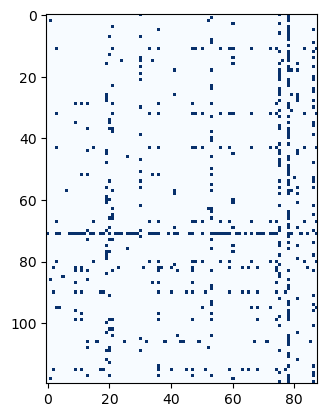

0 66


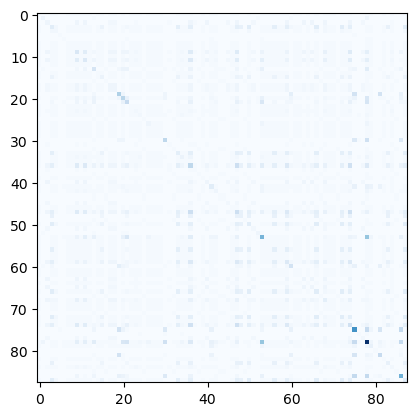

0 53


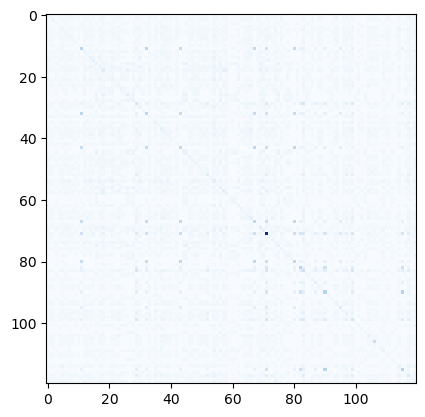

In [14]:

matrix = []
for agreement in bosnia_from_vertices:
    row = [0]*len(bosnia_to_vertices)
    for i,actor in enumerate(bosnia_to_vertices):
        if actor in edge_dict[agreement]:
            row[i] = 1
    matrix.append(row)

matrix = np.array(matrix)

plt.imshow(matrix,cmap=plt.cm.Blues)
plt.show()

# Actor-actor co-occurence matrix
V = np.matmul(matrix.T,matrix)
print(np.amin(V),np.amax(V))

fig, ax = plt.subplots()
ax.imshow(V,cmap=plt.cm.Blues)
plt.show()

# Agreement-agreement co-occurence matrix
W = np.matmul(matrix,matrix.T)
print(np.amin(W),np.amax(W))

plt.imshow(W,cmap=plt.cm.Blues)
plt.show()


### Analyse the actor co-occurence matrix

#### Network visualisations

In [15]:
# Upper triangle without diagonal
u = np.triu(V,k=1)
cooccurence_count = 12

actor_slider = widgets.IntSlider(
    value=12,
    min=2,
    max=np.amax(u),
    step=1,
    description='Value:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

display(actor_slider)


IntSlider(value=12, continuous_update=False, description='Value:', max=26, min=2)

Number of agreements: 120



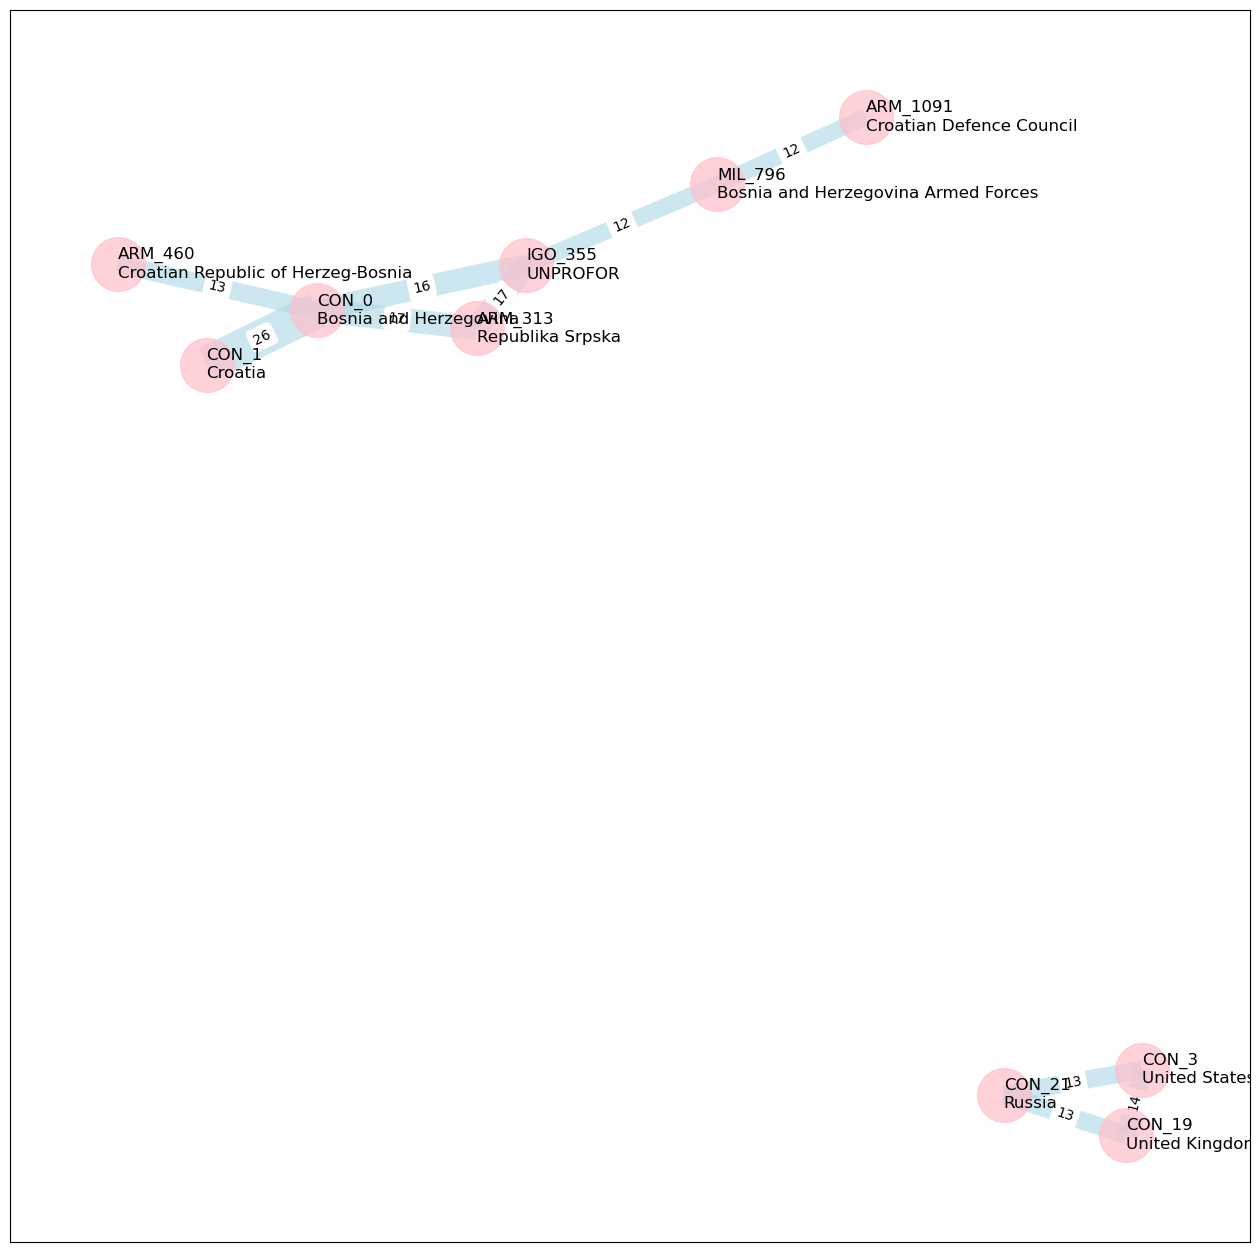

In [16]:
print('Number of agreements:',len(bosnia_from_vertices))
print()

cooccurence_count = actor_slider.value

# Upper triangle without diagonal
linked_pairs = []
for i,row in enumerate(u): 
    linked_pairs.extend([(i,v,j) for j,v in enumerate(row) if v >= cooccurence_count])

actor_graph = nx.Graph()

vertices = []
vertices.extend([t[0] for t in linked_pairs])
vertices.extend([t[2] for t in linked_pairs])
vertices = list(set(vertices))
actor_graph.add_nodes_from(vertices)
for pair in linked_pairs:
    actor_graph.add_edge(pair[0],pair[2],weight=pair[1])

labels = {i:v+'\n'+vertices_dict[v][5] for i,v in enumerate(bosnia_to_vertices) if i in vertices}

f = plt.figure(figsize=(16,16))
pos = nx.spring_layout(actor_graph) 

nx.draw_networkx_nodes(actor_graph,pos,
                       nodelist=vertices,
                       node_size=1500,
                       node_color='pink',
                       alpha=0.7)
nx.draw_networkx_edges(actor_graph,pos,
                       edgelist = [(t[0],t[2]) for t in linked_pairs],
                       width=[t[1] for t in linked_pairs],
                       edge_color='lightblue',
                       alpha=0.6)
nx.draw_networkx_labels(actor_graph, pos=pos,
                        labels=labels,
                        horizontalalignment='left',
                        font_color='black')
nx.draw_networkx_edge_labels(actor_graph, pos=pos,
                        edge_labels={(t[0],t[2]):t[1] for t in linked_pairs},
                        font_color='black')

#nx.draw_networkx(actor_graph,pos,labels=labels,horizontalalignment='left',node_color='pink',node_size=1000)


plt.grid(False)
#plt.box(False)


In [17]:
# verify
b = []
c = []
a_list = ['CON_0','CON_1']
for e in bosnia_edges:
    if e[12] == a_list[0]:
        b.append(e[5])
    if e[12] == a_list[1]:
        c.append(e[5])
        
common = set(b).intersection(set(c))
print(common)
print(len(common))


{'AGT_2', 'AGT_1570', 'AGT_1478', 'AGT_1482', 'AGT_1609', 'AGT_1567', 'AGT_1206', 'AGT_1589', 'AGT_608', 'AGT_77', 'AGT_78', 'AGT_1207', 'AGT_1214', 'AGT_1476', 'AGT_472', 'AGT_1610', 'AGT_1030', 'AGT_1289', 'AGT_1212', 'AGT_1628', 'AGT_606', 'AGT_1202', 'AGT_1201', 'AGT_1320', 'AGT_389', 'AGT_1619'}
26


#### Diagonal of $V$

Provides the actor (columns) marginal from $A$, i.e., actor counts across all agreements.


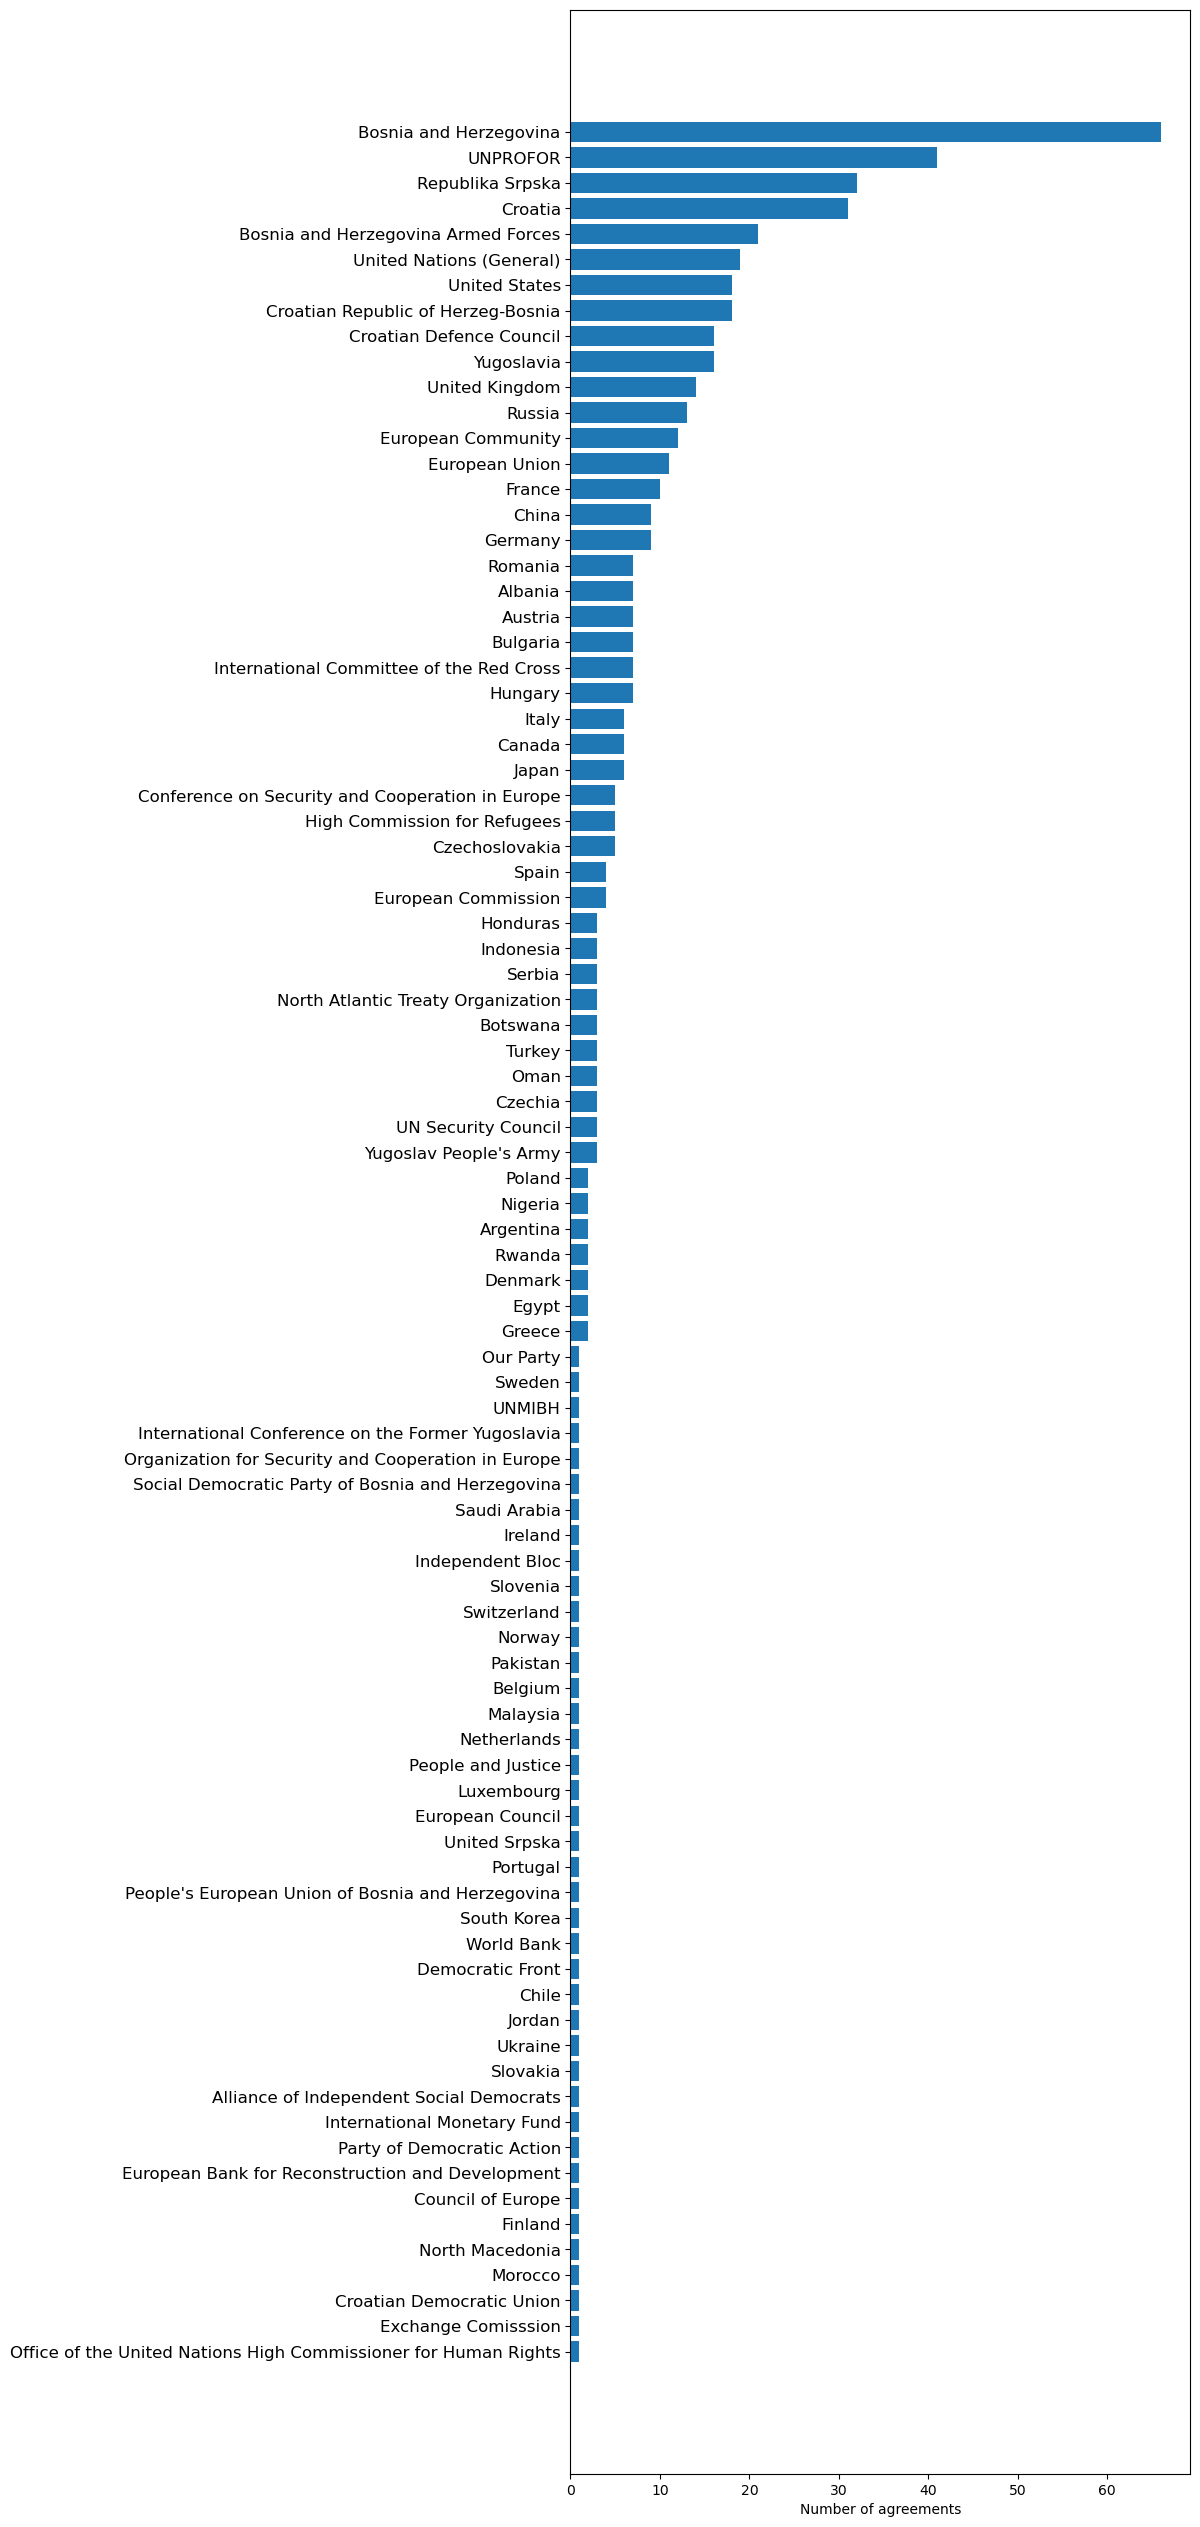

In [18]:
actor_diag = np.diag(V)

# Plot

labels = [vertices_dict[v][5] for i,v in enumerate(bosnia_to_vertices)]
z = list(zip(labels,actor_diag))
z = sorted(z,key=lambda t:t[1])

f = plt.figure(figsize=(8,32))
plt.barh(range(0,len(actor_diag)),[t[1] for t in z])
plt.yticks(range(0,len(actor_diag)),[t[0] for t in z],fontsize='large')
plt.xlabel('Number of agreements')
plt.show()


#### Distribution of actor co-occurence counts

- Excluding 0 and 1


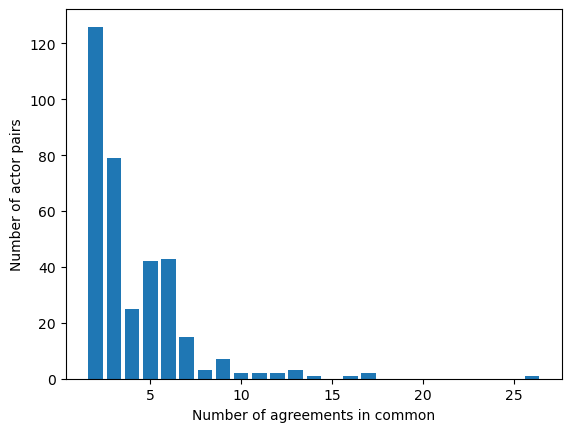

In [19]:

counts_dict = {}
for x in u.flatten():
    if x <= 1:
        continue
    if x in counts_dict:
        counts_dict[x] += 1
    else:
        counts_dict[x] = 1

plt.bar(list(counts_dict.keys()),list(counts_dict.values()))
plt.ylabel('Number of actor pairs')
plt.xlabel('Number of agreements in common')
plt.show()


### Query agreements co-occurence matrix


In [20]:
v = np.triu(W,k=1)
cooccurence_count = 10

agree_slider = widgets.IntSlider(
    value=10,
    min=2,
    max=np.amax(v),
    step=1,
    description='Value:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

display(agree_slider)


IntSlider(value=10, continuous_update=False, description='Value:', max=16, min=2)

Number of actors: 88



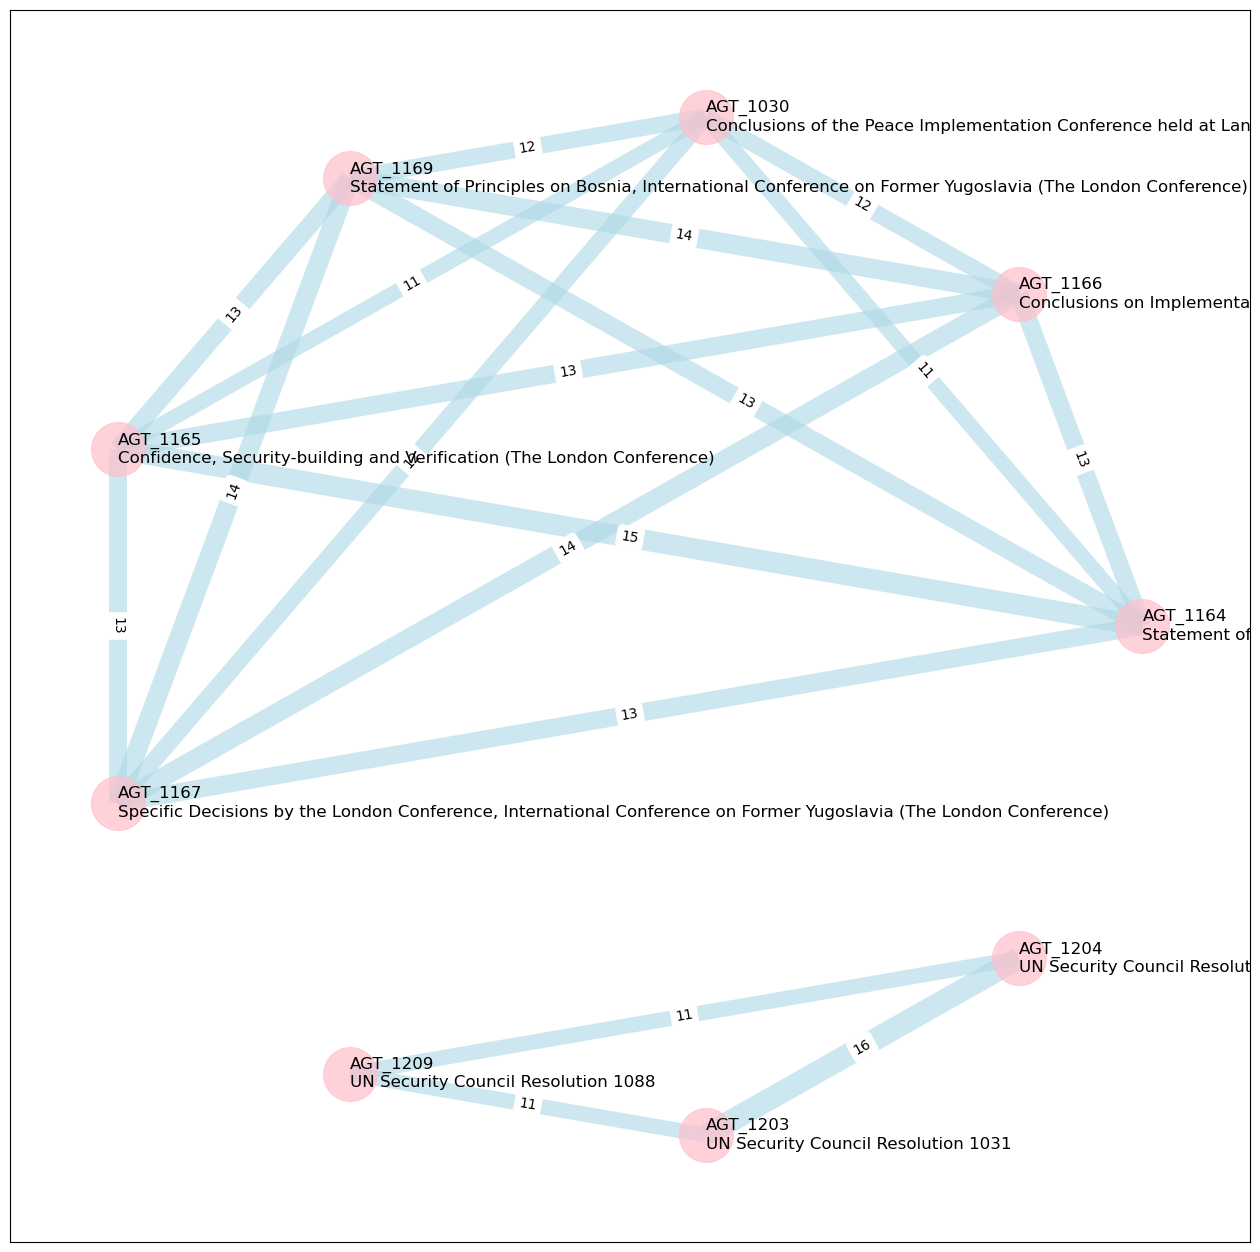

In [21]:
import math

print('Number of actors:',len(bosnia_to_vertices))
print()

# Define agreement-agreement actor co-occurence counts
cooccurence_count = agree_slider.value

linked_pairs = []
for i,row in enumerate(v):    
    linked_pairs.extend([(i,v,j) for j,v in enumerate(row) if v >= cooccurence_count])

actor_graph = nx.Graph()

vertices = []
vertices.extend([t[0] for t in linked_pairs])
vertices.extend([t[2] for t in linked_pairs])
vertices = list(set(vertices))
actor_graph.add_nodes_from(vertices)
for pair in linked_pairs:
    actor_graph.add_edge(pair[0],pair[2],weight=pair[1])

labels = {i:v+'\n'+vertices_dict[v][5] for i,v in enumerate(bosnia_from_vertices) if i in vertices}

f = plt.figure(figsize=(16,16))
pos = nx.circular_layout(actor_graph) 

nx.draw_networkx_nodes(actor_graph,pos,
                       nodelist=vertices,
                       node_size=1500,
                       node_color='pink',
                       alpha=0.7)
nx.draw_networkx_edges(actor_graph,pos,
                       edgelist = [(t[0],t[2]) for t in linked_pairs],
                       width=[t[1] for t in linked_pairs],
                       edge_color='lightblue',
                       alpha=0.6)
nx.draw_networkx_labels(actor_graph, pos=pos,
                        labels=labels,
                        horizontalalignment='left',
                        font_color='black')
nx.draw_networkx_edge_labels(actor_graph, pos=pos,
                        edge_labels={(t[0],t[2]):t[1] for t in linked_pairs},
                        font_color='black')

#nx.draw_networkx(actor_graph,pos,labels=labels,horizontalalignment='left',node_color='pink',node_size=1000)
plt.grid(False)


In [22]:
# verify for slider value = 10
b = []
common = set(bosnia_to_vertices)
# These should have a least 10 in common
a_list = ['AGT_1203','AGT_1204','AGT_1209']
for a in a_list:
    c = []
    for e in bosnia_edges:
        if e[5] == a:
            c.append(e[12])
    common = common.intersection(set(c))
    
print(common)
print(len(common))
print()

# These should have less than 10 in common
a_list = ['AGT_1203','AGT_1204','AGT_1209','AGT_1169']
for a in a_list:
    c = []
    for e in bosnia_edges:
        if e[5] == a:
            c.append(e[12])
    common = common.intersection(set(c))
    
print(common)
print(len(common))
print()


{'CON_267', 'CON_7', 'CON_162', 'CON_19', 'CON_621', 'IGO_8', 'CON_2', 'CON_21', 'CON_20', 'CON_3', 'CON_139'}
11

{'CON_21', 'CON_20', 'CON_3', 'CON_19'}
4



#### Diagonal of $W$

Provides the agreement (rows) marginal from $A$, i.e., actor counts for each agreements.


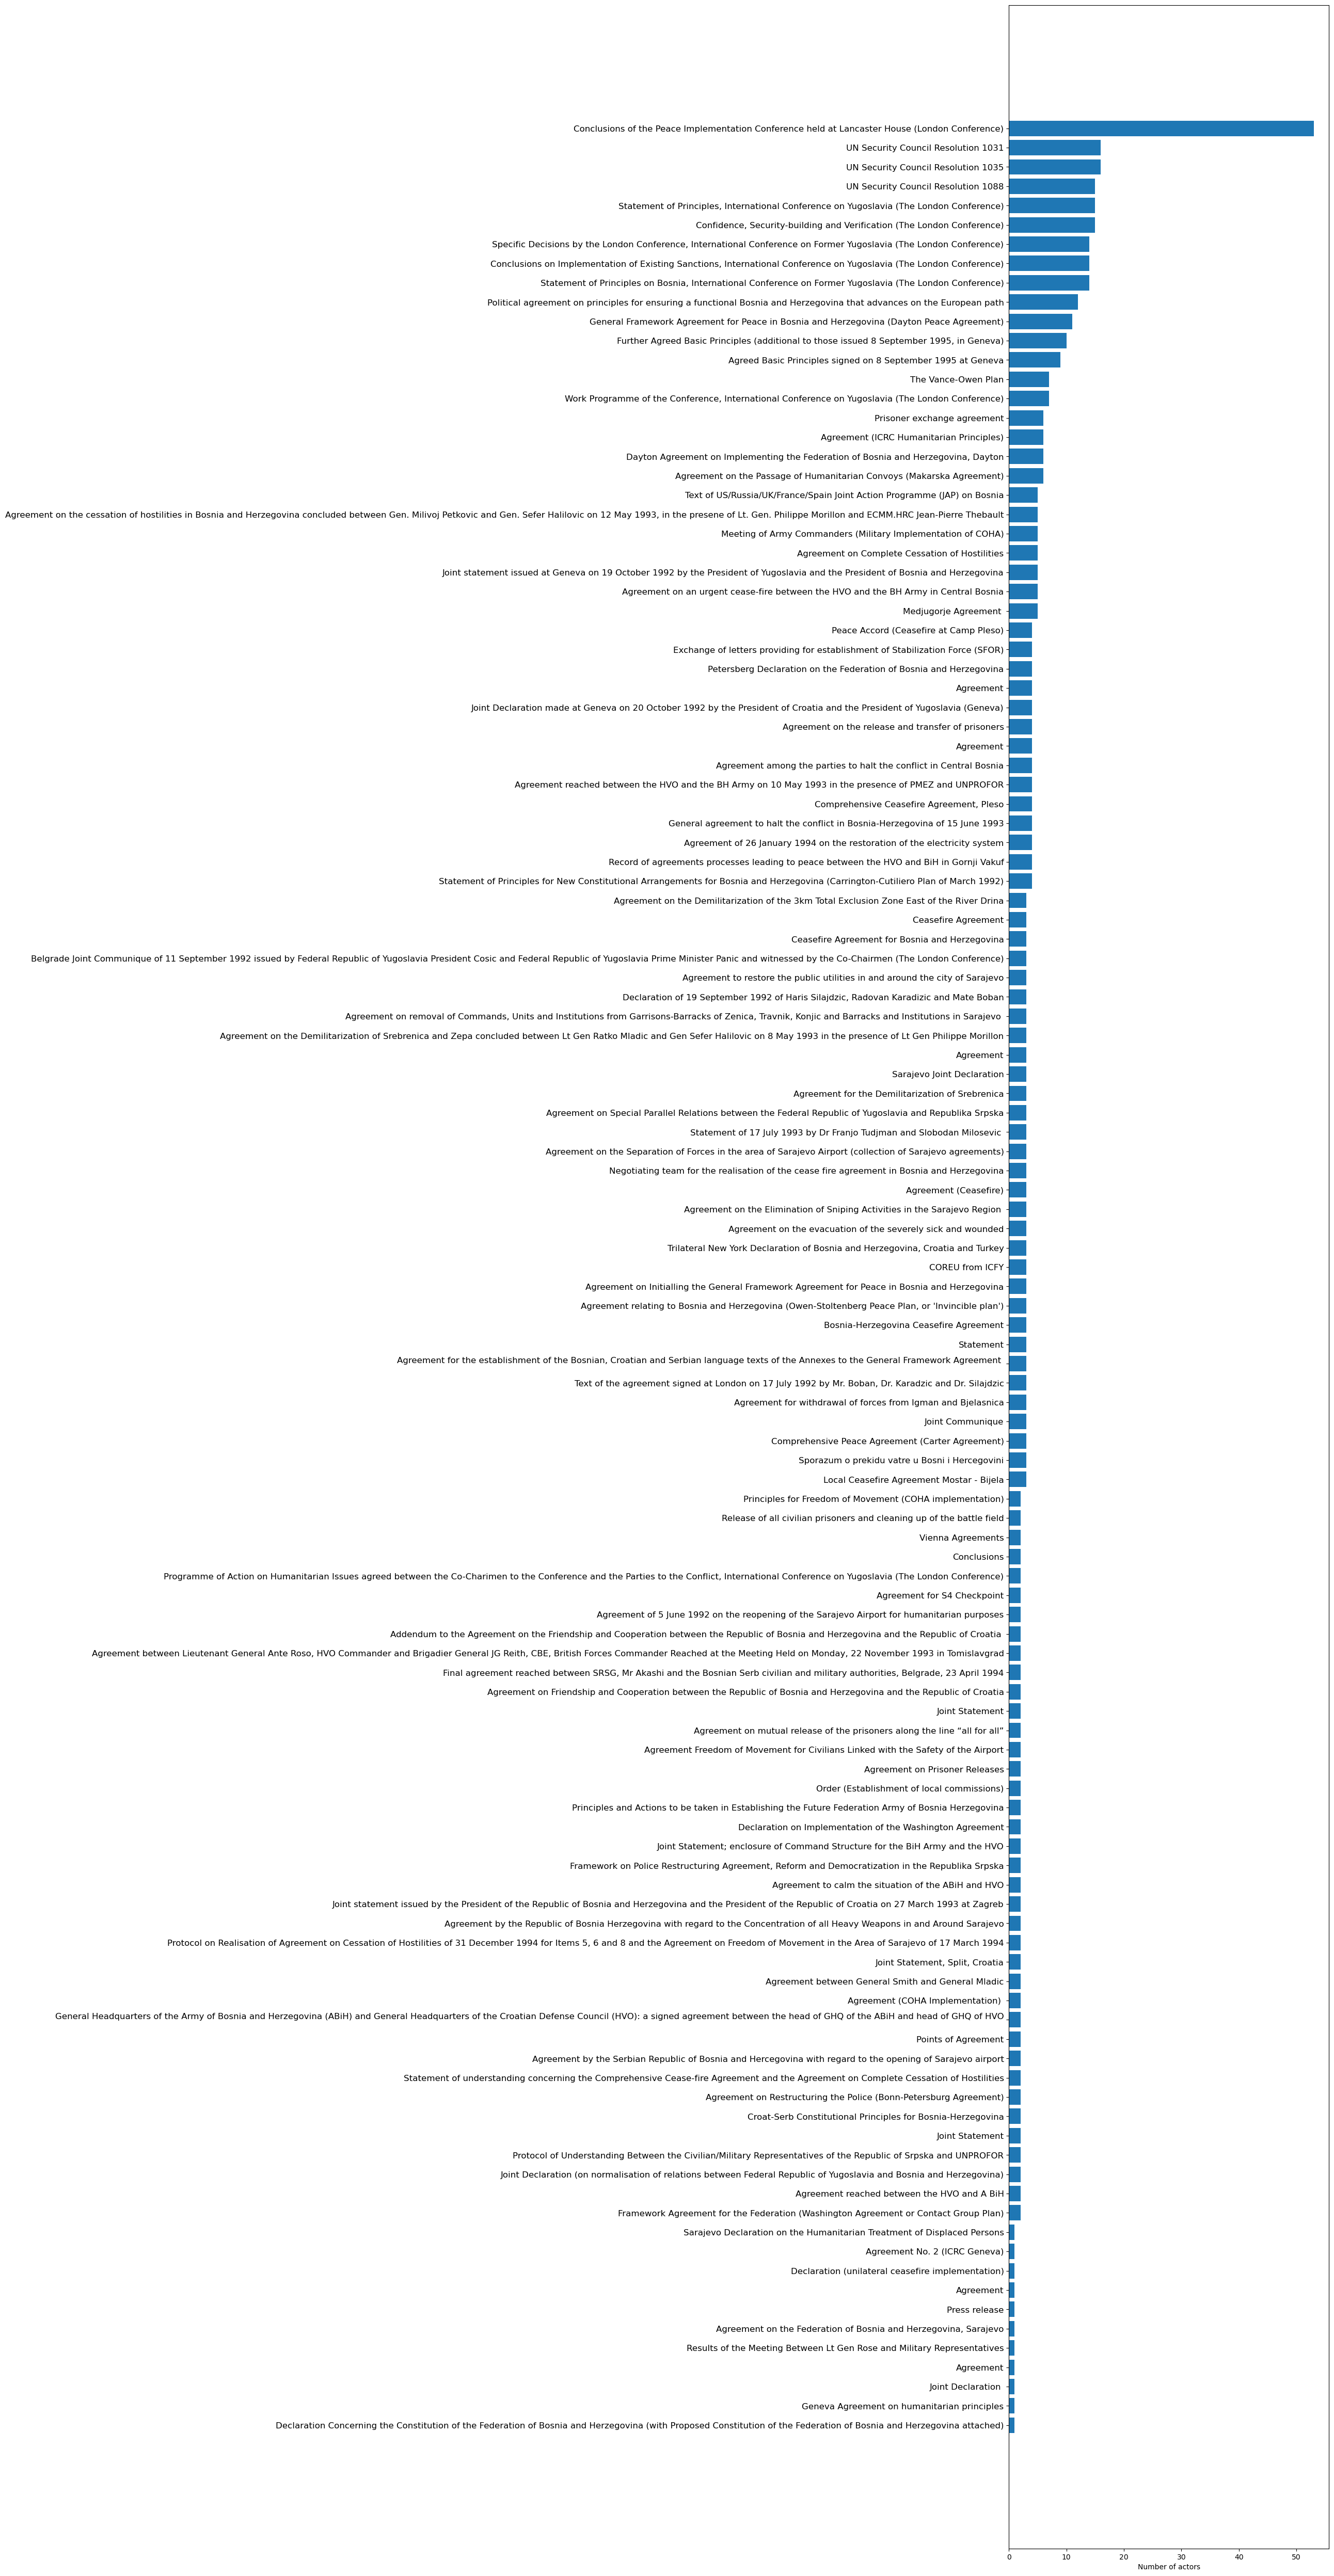

In [23]:
agree_diag = np.diag(W)

# Plot

labels = [vertices_dict[v][5] for i,v in enumerate(bosnia_from_vertices)]
z = list(zip(labels,agree_diag))
z = sorted(z,key=lambda t:t[1])

f = plt.figure(figsize=(8,64))
plt.barh(range(0,len(agree_diag)),[t[1] for t in z])
plt.xlabel('Number of actors')
plt.yticks(range(0,len(agree_diag)),[t[0] for t in z],fontsize='large')
plt.show()


#### Distribution of actor co-occurence counts

- Excluding 0 and 1


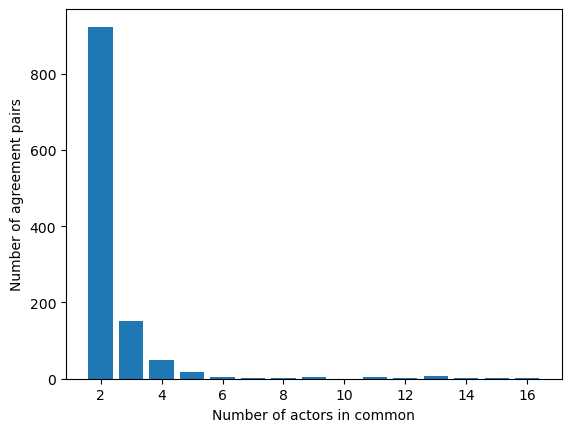

In [24]:

counts_dict = {}
for x in v.flatten():
    if x <= 1:
        continue
    if x in counts_dict:
        counts_dict[x] += 1
    else:
        counts_dict[x] = 1

plt.bar(list(counts_dict.keys()),list(counts_dict.values()))
plt.ylabel('Number of agreement pairs')
plt.xlabel('Number of actors in common')
plt.show()


## Build all agreement-actor matrix

(1642, 1092)


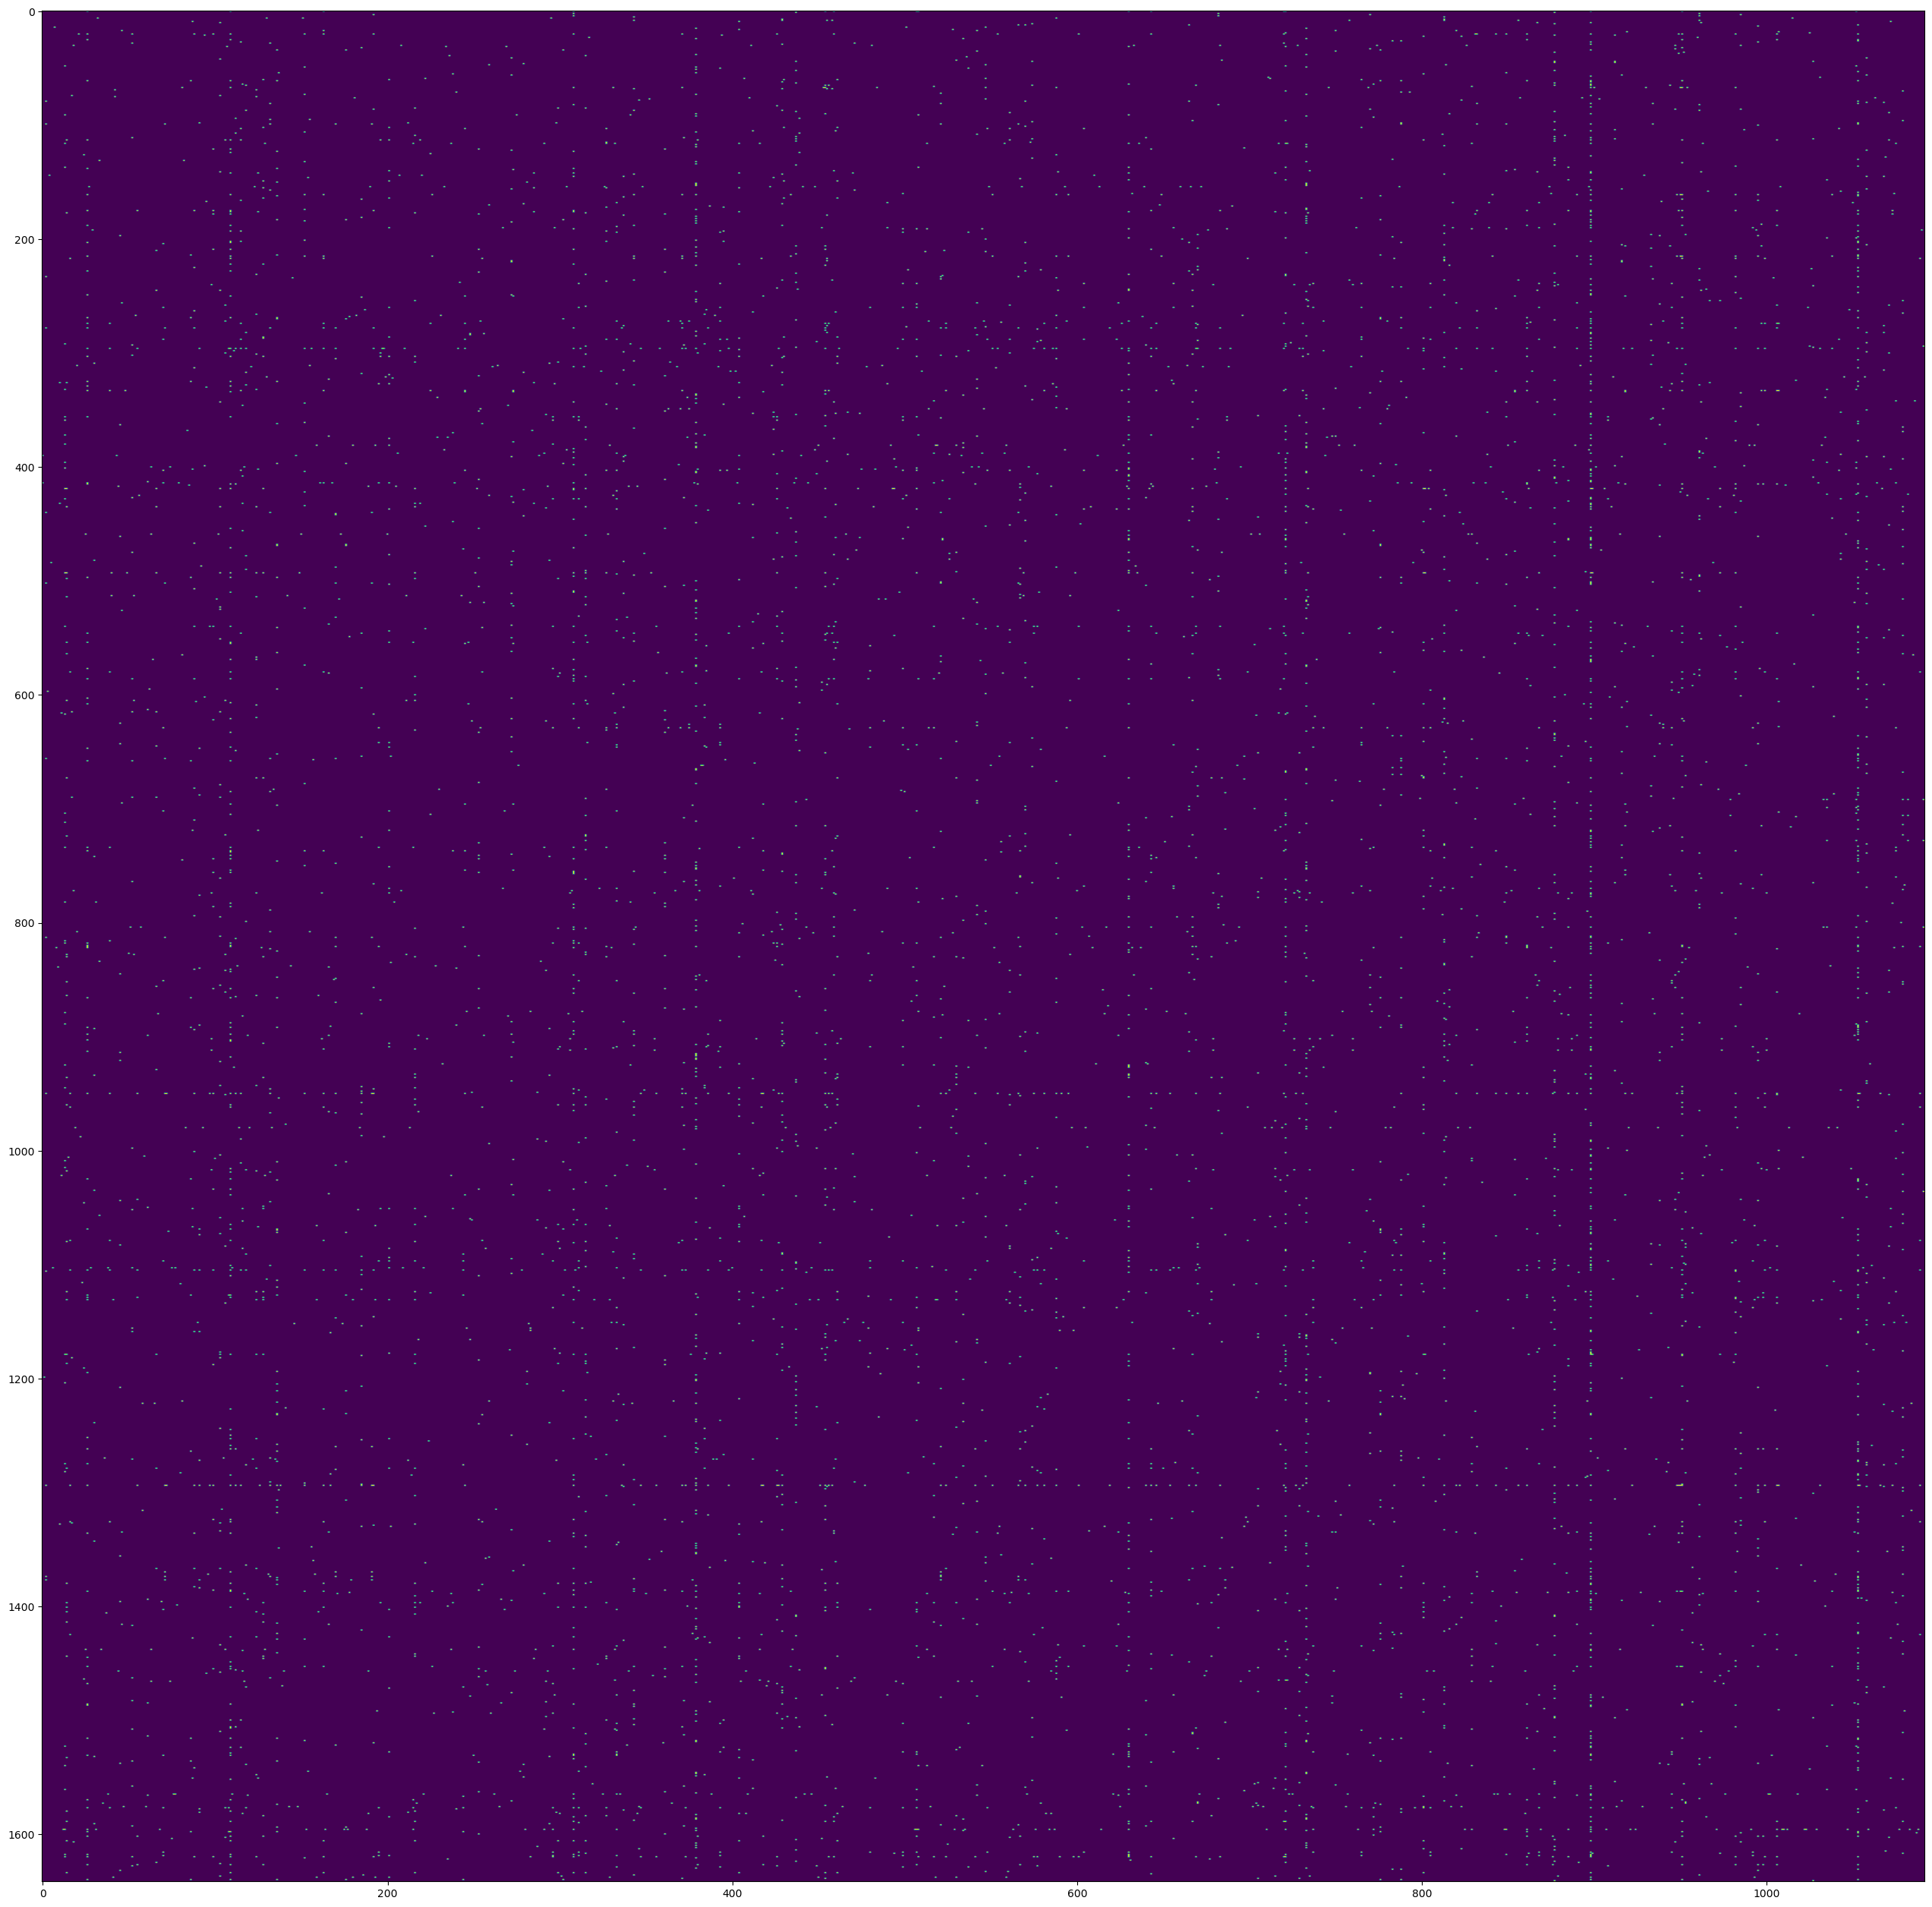

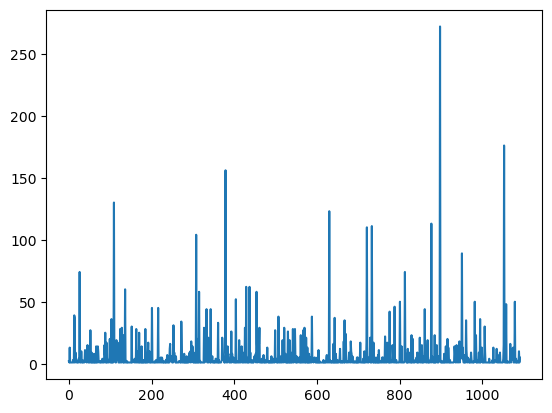

IGO_49 United Nations (General)


In [25]:
from_vertices = list(set([row[links_header.index('from_node_id')] for row in links_data]))
to_vertices = list(set([row[links_header.index('to_node_id')] for row in links_data]))

all_edge_dict = {}
for row in links_data:
    if row[5] in all_edge_dict:
        all_edge_dict[row[5]].append(row[12])
    else:
        all_edge_dict[row[5]] = [row[12]]

complete_matrix = []
for agreement in from_vertices:
    row = [0]*len(to_vertices)
    for i,actor in enumerate(to_vertices):
        if actor in all_edge_dict[agreement]:
            row[i] = 1
    complete_matrix.append(row)

complete_matrix = np.array(complete_matrix)
print(complete_matrix.shape)

f = plt.figure(figsize=(32,32))
plt.imshow(complete_matrix,aspect='auto')
plt.show()

# Get the column marginals
col_marginals = []
for row in complete_matrix.T:
    col_marginals.append(sum(row))


plt.plot(range(0,len(col_marginals)),col_marginals)
plt.show()

max_i = col_marginals.index(max(col_marginals))
max_actor = to_vertices[max_i]
print(max_actor,vertices_dict[max_actor][5])
